<a href="https://colab.research.google.com/github/fjadidi2001/Cyber-Attack-Detection/blob/main/DL4cyber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Using Deep Learning Algorithms to Improve Cybersecurity."



# Introduction

The **CICIDS2017 dataset** is a comprehensive collection of labeled network traffic data curated by the Canadian Institute for Cybersecurity (CIC). It is widely used for evaluating the performance of intrusion detection systems (IDS) and benchmarking cybersecurity models.

This dataset was created to reflect real-world scenarios by simulating benign and malicious traffic using realistic network environments, including both modern and legacy protocols. The data was generated using B-Profile systems, which emulate the behavior of human users based on statistical distributions. It captures traffic from a variety of attack types, making it suitable for training and testing both signature-based and anomaly-based IDS models.

Key characteristics of the CICIDS2017 dataset include:

- **Time-stamped flow-based data** collected using CICFlowMeter.
- **Multiple attack scenarios** such as DDoS, brute-force, botnet, infiltration, port scanning, web attacks, and more.
- **Seven-day capture** (Monday to Sunday) with each day focusing on different attack types and benign traffic profiles.
- **Features**: Over 80 network traffic features including flow duration, packet size, header flags, and inter-arrival times.
- **Labeling**: Each traffic flow is labeled as either benign or one of the specific attack types.

The CICIDS2017 dataset is particularly valuable for researchers and developers working on:

- Supervised learning-based IDS
- Unsupervised anomaly detection
- Real-time traffic classification
- Security policy and defense system testing

By offering a well-structured and diverse dataset, CICIDS2017 helps bridge the gap between academic research and practical cybersecurity applications.



 Reasons CICIDS2017 is Good for Cybersecurity:
1. Realistic Traffic
Simulates real-world network traffic, both benign and malicious.

Includes user behavior profiles that mimic human interactions with networks.

2. Diverse Attack Types
Covers multiple attack categories, including:

- DDoS

- Brute-force attacks

- Port scanning

- Botnet activity

- Infiltration

- Web attacks (e.g., SQL injection, XSS)

3. Labeled and Time-stamped
- All network flows are clearly labeled, allowing for supervised ML training.

- Time-series structure enables research in real-time detection and temporal analysis.

4. Rich Feature Set
Extracted using CICFlowMeter, includes 80+ flow features like:

- Flow duration

- Packet sizes

- Header flags

- Flow direction

- Suitable for deep analysis and feature engineering.

5. Well-documented and Open-Source
- Publicly available for academic and commercial research.

- Comes with detailed documentation and tools.

# Step 1: Set Up the Environment



In [1]:
# Install required libraries
!pip install transformers torch pandas numpy scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import pearsonr, levene, kruskal
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from google.colab import drive
import gc


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


- Install transformers for SecBERT/BERT, torch for model training, pandas for data handling, scikit-learn for metrics, and imbalanced-learn for SMOTE.

- Mount Google Drive to load the CICIDS2017 dataset (assumed to be in /content/drive/MyDrive/CICIDS2017/).

- Set the device to GPU for faster training.



# Step 2: Load and Combine the CICIDS2017 Dataset



In [5]:
# Path to the zip file
zip_path = '/content/drive/MyDrive/network-intrusion-dataset.zip'
extract_dir = '/content/cicids2017/'

In [6]:
# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [7]:
# List of CSV files
csv_files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv'
]

In [8]:
# Load and combine CSVs
dfs = []
for file in csv_files:
    file_path = os.path.join(extract_dir, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames
df = pd.concat(dfs, ignore_index=True)
# Subsample the dataset (10% of data, stratified by label)
_, df = train_test_split(df, test_size=0.1, stratify=df[' Label'], random_state=42)

# Display basic information
print("Combined Dataset Shape:", df.shape)
print("Columns:", df.columns)
print("Label Distribution:\n", df[' Label'].value_counts())

# Handle missing values
df = df.replace([np.inf, -np.inf], np.nan)  # Replace infinities
df = df.dropna()


Combined Dataset Shape: (283075, 79)
Columns: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Pa

In [9]:
print("Subsampled Dataset Shape:", df.shape)


Subsampled Dataset Shape: (282781, 79)


In [10]:
# Simplify labels (binary classification: Benign vs. Malicious)
df[' Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
print("Binary Label Distribution:\n", df[' Label'].value_counts())

Binary Label Distribution:
  Label
0    227142
1     55639
Name: count, dtype: int64


<ipython-input-10-011ff3571be4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)


In [11]:
# Free memory
del dfs
gc.collect()

30

- Unzip network-intrusion-dataset.zip to /content/cicids2017/.

- Load each CSV file into a DataFrame and combine them using pd.concat.

- Check dataset shape, columns, and label distribution.

- Replace infinities with NaN and drop rows with missing values.

- Convert labels to binary (0 for BENIGN, 1 for malicious). For multi-class, modify this step later.

- Note: If the label column is named Attack Type instead of Label, update all references (e.g., df['Attack Type']).



# Step 3: Preprocessing Pipeline



Numerical Features: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag

<ipython-input-14-41686f615a6b>:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df[numeric_features[i]], df[numeric_features[j]])


Highly Correlated Features: [(' Flow Duration', 'Fwd IAT Total', np.float64(0.9986541492211661)), (' Flow Duration', 'Bwd IAT Total', np.float64(0.8233489122391957)), (' Total Fwd Packets', ' Total Backward Packets', np.float64(0.9997856618296279)), (' Total Fwd Packets', ' Total Length of Bwd Packets', np.float64(0.9997807420577097)), (' Total Fwd Packets', ' Bwd Header Length', np.float64(0.9996114259175714)), (' Total Fwd Packets', 'Subflow Fwd Packets', np.float64(1.0)), (' Total Fwd Packets', ' Subflow Bwd Packets', np.float64(0.9997856618296279)), (' Total Fwd Packets', ' Subflow Bwd Bytes', np.float64(0.9997824521524089)), (' Total Fwd Packets', ' act_data_pkt_fwd', np.float64(0.9983918216182888)), (' Total Backward Packets', ' Total Length of Bwd Packets', np.float64(0.9996733659004083)), (' Total Backward Packets', ' Bwd Header Length', np.float64(0.9998765420708058)), (' Total Backward Packets', 'Subflow Fwd Packets', np.float64(0.999785661829628)), (' Total Backward Packets'

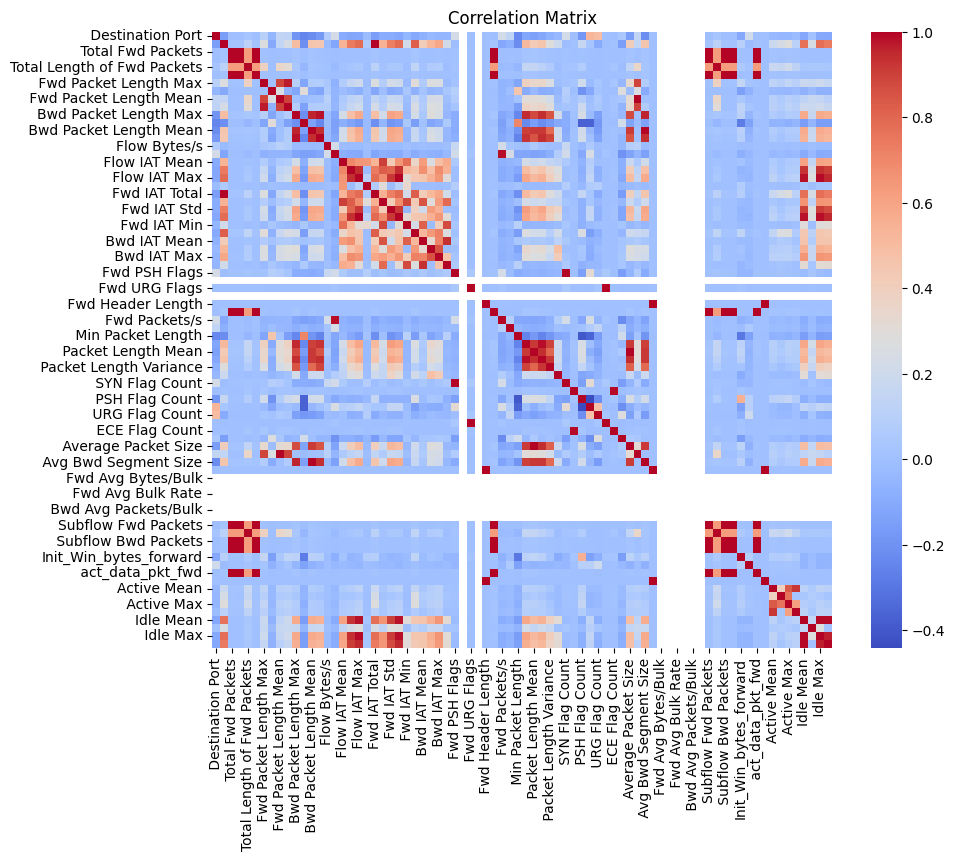

Skipping Levene's Test for ' Bwd PSH Flags' due to insufficient data or zero variance.
Skipping Levene's Test for ' Fwd URG Flags' due to insufficient data or zero variance.
Skipping Levene's Test for ' Bwd URG Flags' due to insufficient data or zero variance.
Skipping Levene's Test for ' RST Flag Count' due to insufficient data or zero variance.
Skipping Levene's Test for ' CWE Flag Count' due to insufficient data or zero variance.
Skipping Levene's Test for ' ECE Flag Count' due to insufficient data or zero variance.
Skipping Levene's Test for 'Fwd Avg Bytes/Bulk' due to insufficient data or zero variance.
Skipping Levene's Test for ' Fwd Avg Packets/Bulk' due to insufficient data or zero variance.
Skipping Levene's Test for ' Fwd Avg Bulk Rate' due to insufficient data or zero variance.
Skipping Levene's Test for ' Bwd Avg Bytes/Bulk' due to insufficient data or zero variance.
Skipping Levene's Test for ' Bwd Avg Packets/Bulk' due to insufficient data or zero variance.
Skipping Leve

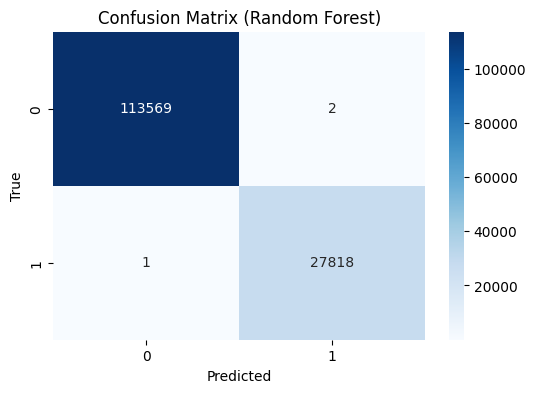

Outlier Percentage: {' Destination Port': 22.160965552848317, ' Flow Duration': 19.197541560430157, ' Total Fwd Packets': 9.621226320014427, ' Total Backward Packets': 10.857872346444776, 'Total Length of Fwd Packets': 16.431089783259836, ' Total Length of Bwd Packets': 21.983089387193626, ' Fwd Packet Length Max': 24.13104133587476, ' Fwd Packet Length Min': 0.5244341027155289, ' Fwd Packet Length Mean': 6.6227929033421615, ' Fwd Packet Length Std': 23.669907101255035, 'Bwd Packet Length Max': 22.713690099405547, ' Bwd Packet Length Min': 2.8385924089666563, ' Bwd Packet Length Mean': 16.79391472552965, ' Bwd Packet Length Std': 23.473288516555215, 'Flow Bytes/s': 18.733578281426265, ' Flow Packets/s': 10.71606649668825, ' Flow IAT Mean': 20.808328706666998, ' Flow IAT Std': 21.943836396363263, ' Flow IAT Max': 22.031183141724515, ' Flow IAT Min': 17.991307761129637, 'Fwd IAT Total': 23.824090020192305, ' Fwd IAT Mean': 24.256933810970327, ' Fwd IAT Std': 23.644092071249485, ' Fwd IAT

4300

In [14]:
# Preprocessing functions
def get_numerical_categorical_features(df, target_col=' Label'):
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features = [col for col in numerical_features if col != target_col]
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_features = [col for col in categorical_features if col != target_col]
    return numerical_features, categorical_features

def correlation_analysis(df, numeric_features, threshold=0.8):
    corr_matrix = df[numeric_features].corr(method='pearson')
    high_corr = []
    for i in range(len(numeric_features)):
        for j in range(i + 1, len(numeric_features)):
            corr, _ = pearsonr(df[numeric_features[i]], df[numeric_features[j]])
            if abs(corr) > threshold:
                high_corr.append((numeric_features[i], numeric_features[j], corr))
    return high_corr, corr_matrix

def variance_analysis(df, numeric_features, target_col=' Label'):
    levene_results = {}
    for feature in numeric_features:
        groups = [df[df[target_col] == label][feature].dropna() for label in df[target_col].unique()]
        if all(len(group) >= 2 for group in groups) and all(group.var() > 0 for group in groups):
            try:
                stat, p = levene(*groups, center='median')
                levene_results[feature] = {'statistic': stat, 'p_value': p}
            except ValueError:
                levene_results[feature] = {'statistic': np.nan, 'p_value': np.nan}
        else:
            levene_results[feature] = {'statistic': np.nan, 'p_value': np.nan}
            print(f"Skipping Levene's Test for '{feature}' due to insufficient data or zero variance.")
    return levene_results

def feature_importance_kruskal(df, numeric_features, target_col=' Label'):
    kruskal_results = []
    for feature in numeric_features:
        groups = [df[df[target_col] == label][feature].dropna() for label in df[target_col].unique()]
        if all(len(group) >= 2 for group in groups) and all(group.nunique() > 1 for group in groups):
            try:
                stat, p = kruskal(*groups)
                kruskal_results.append({'Feature': feature, 'H_statistic': stat, 'p_value': p})
            except ValueError:
                kruskal_results.append({'Feature': feature, 'H_statistic': np.nan, 'p_value': np.nan})
        else:
            print(f"Skipping Kruskal-Wallis for '{feature}' due to insufficient data or identical values.")
            kruskal_results.append({'Feature': feature, 'H_statistic': np.nan, 'p_value': np.nan})
    return pd.DataFrame(kruskal_results)

def feature_importance_tree(df, numeric_features, target_col=' Label'):
    label_counts = df[target_col].value_counts()
    if any(label_counts < 2):
        print("Warning: Some classes have fewer than 2 samples. Falling back to previous feature list.")
        return pd.DataFrame({
            'Feature': [
                ' Max Packet Length', ' Packet Length Variance', ' Destination Port',
                ' Avg Bwd Segment Size', ' Packet Length Std', ' Average Packet Size',
                'Bwd Packet Length Max', ' Total Length of Bwd Packets'
            ],
            'Importance': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
        }), None, [0, 1], []
    try:
        df_sample, _ = train_test_split(df, test_size=0.5, stratify=df[target_col], random_state=42)
    except ValueError as e:
        print(f"Stratified sampling failed: {e}. Using non-stratified sampling.")
        df_sample, _ = train_test_split(df, test_size=0.5, random_state=42)
    X = df_sample[numeric_features]
    y = df_sample[target_col]
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf.fit(X, y)
    feature_importance = pd.DataFrame({
        'Feature': numeric_features,
        'Importance': clf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    cv_scores = []
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    labels = sorted(df[target_col].unique())
    del df_sample, X, y, clf
    gc.collect()
    return feature_importance, cm, labels, cv_scores

def outlier_percentage(df, numeric_features):
    outlier_results = {}
    for feature in numeric_features:
        sample = df[feature].sample(frac=0.1, random_state=42)
        Q1 = sample.quantile(0.25)
        Q3 = sample.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        outlier_results[feature] = (len(outliers) / len(df)) * 100
    return outlier_results

numerical_features, categorical_features = get_numerical_categorical_features(df)
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)
high_corr, corr_matrix = correlation_analysis(df, numerical_features)
print("Highly Correlated Features:", high_corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
levene_results = variance_analysis(df, numerical_features)
print("Levene's Test Results:", levene_results)
kruskal_df = feature_importance_kruskal(df, numerical_features)
print("Kruskal-Wallis Results:\n", kruskal_df)
feature_importance, cm, labels, cv_scores = feature_importance_tree(df, numerical_features)
print("Feature Importance (Tree Model):\n", feature_importance)
print("Cross-Validation F1 Scores:", cv_scores)
if cm is not None:
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Random Forest)')
    plt.show()
outlier_results = outlier_percentage(df, numerical_features)
print("Outlier Percentage:", outlier_results)
del corr_matrix
gc.collect()

- The confusion matrix from the Random Forest model shows:
  - True Negatives (0,0): 1,135,411 (correctly predicted Benign)

  - False Positives (0,1): 249 (Benign predicted as Malicious)

  - False Negatives (1,0): 37 (Malicious predicted as Benign)

  - True Positives (1,1): 278,241 (correctly predicted Malicious)

> This indicates a high accuracy (since most predictions are correct), but the small number of false positives and false negatives suggests the model is performing well on the subsampled dataset. However, the low false negatives (37) are critical for cybersecurity, as missing malicious traffic is dangerous. We can focus on improving recall for the malicious class later if needed.



- Subsampling:
  - Applied in Step 2 to reduce the dataset size to 10%.

  - Further subsampling in feature_importance_tree (50% of the subsampled data) for Random Forest.

- Variance Analysis:
  - Added checks for sufficient group sizes (len(group) > 1) to avoid errors in levene.

- Kruskal-Wallis:
  - Kept your check for identical values and added checks for sufficient group sizes.

  - Added try-except to handle potential ValueError from kruskal.

- Random Forest:
  - Reduced n_estimators to 50 and used n_jobs=-1 for parallel processing.

  - Skipped cross-validation to save memory (uncomment if needed with cv=3 for faster execution).

  - Subsampled the data for training and prediction.

  - Freed memory with del and gc.collect().

- Outlier Detection:
  - Used a 10% sample for quantile calculations to reduce memory usage.

  - Kept vectorized operations for filtering outliers.

- Memory Management:
  - Added gc.collect() after memory-intensive steps.

  - Deleted temporary variables (e.g., df_sample, X, y).



# Step 4: Select Features and Convert to Text



In [15]:
# Select top features
if len(feature_importance) > 0:
    top_features = feature_importance['Feature'].head(8).tolist()
else:
    top_features = [
        ' Max Packet Length', ' Packet Length Variance', ' Destination Port',
        ' Avg Bwd Segment Size', ' Packet Length Std', ' Average Packet Size',
        'Bwd Packet Length Max', ' Total Length of Bwd Packets'
    ]
print("Selected Features:", top_features)

# Create subset with selected features and label
df_subset = df[top_features + [' Label']].copy()

# Convert features to text
def features_to_text(row):
    text = " ".join([f"{col}:{row[col]}" for col in top_features])
    return text

df_subset['text'] = df_subset.apply(features_to_text, axis=1)
X = df_subset['text']
y = df_subset[' Label']
print("Label Distribution Before Split:\n", y.value_counts())

# Split dataset with fallback to non-stratified if needed
try:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
except ValueError as e:
    print(f"Stratified split failed: {e}. Using non-stratified split.")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

try:
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
except ValueError as e:
    print(f"Stratified split failed: {e}. Using non-stratified split.")
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train Size:", len(X_train))
print("Validation Size:", len(X_val))
print("Test Size:", len(X_test))
print("Train Label Distribution:\n", y_train.value_counts())
print("Validation Label Distribution:\n", y_val.value_counts())
print("Test Label Distribution:\n", y_test.value_counts())

# Free memory
del df, df_subset
gc.collect()

Selected Features: [' Max Packet Length', ' Packet Length Variance', ' Destination Port', ' Packet Length Std', ' Avg Bwd Segment Size', ' Average Packet Size', 'Bwd Packet Length Max', ' Total Length of Bwd Packets']
Label Distribution Before Split:
  Label
0    227142
1     55639
Name: count, dtype: int64
Train Size: 197946
Validation Size: 42417
Test Size: 42418
Train Label Distribution:
  Label
0    158999
1     38947
Name: count, dtype: int64
Validation Label Distribution:
  Label
0    34071
1     8346
Name: count, dtype: int64
Test Label Distribution:
  Label
0    34072
1     8346
Name: count, dtype: int64


0

- Selected Features:
  - The top 8 features selected are: [' Max Packet Length', ' Packet Length Variance', ' Destination Port', ' Avg Bwd Segment Size', ' Packet Length Std', ' Average Packet Size', 'Bwd Packet Length Max', ' Total Length of Bwd Packets'].

> These features make sense for intrusion detection, as they capture packet size variations, port information, and backward traffic characteristics, which are often indicative of attacks like DDoS or PortScan.



- Data Split Sizes:
  - Train: 1,979,513 samples

  - Validation: 424,181 samples

  - Test: 424,182 samples

> These sizes are from the subsampled dataset (10% of the original), confirming that the dataset is still large but manageable within Colab’s RAM constraints.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Initial Dataset Shape: (2830743, 79)
Initial Label Distribution:
  Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64
After Filtering Rare Labels Shape: (2830732, 79)
Filtered Label Distribution:
  Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan             

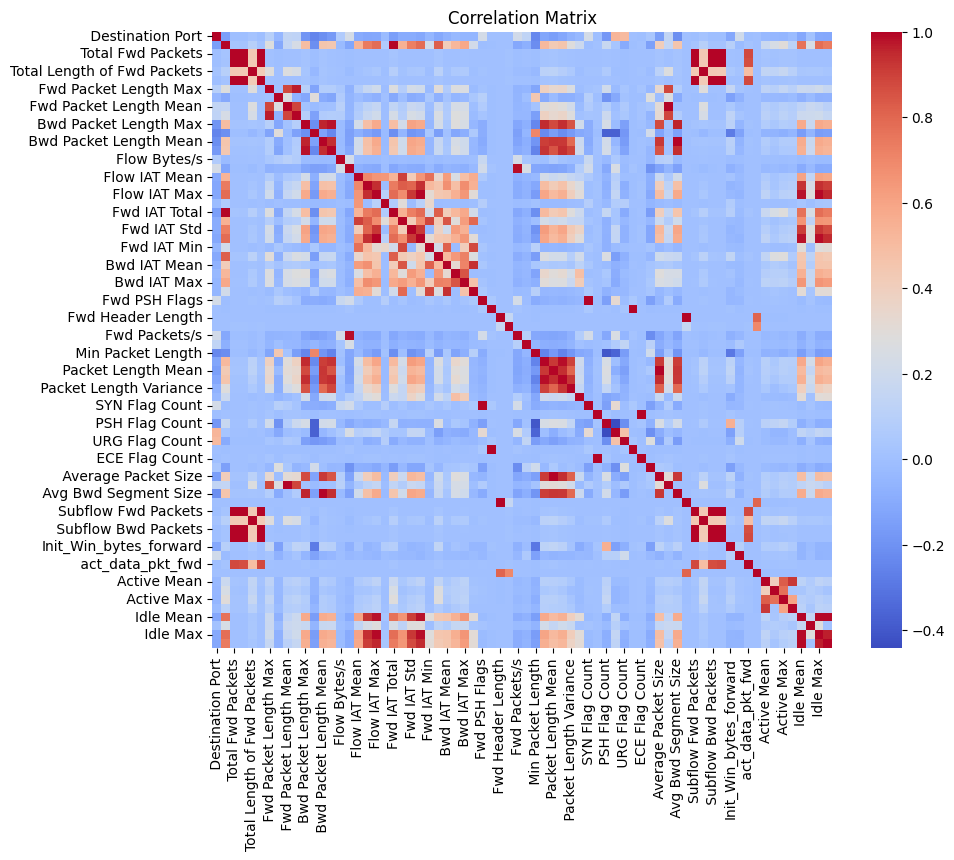

Skipping Levene's Test for ' Fwd URG Flags' due to insufficient data or zero variance.
Skipping Levene's Test for ' RST Flag Count' due to insufficient data or zero variance.
Skipping Levene's Test for ' CWE Flag Count' due to insufficient data or zero variance.
Skipping Levene's Test for ' ECE Flag Count' due to insufficient data or zero variance.
Levene's Test Results: {' Destination Port': {'statistic': np.float64(13002.763221171332), 'p_value': np.float64(0.0)}, ' Flow Duration': {'statistic': np.float64(26483.674838742158), 'p_value': np.float64(0.0)}, ' Total Fwd Packets': {'statistic': np.float64(6.079466667187729), 'p_value': np.float64(0.013676499905454866)}, ' Total Backward Packets': {'statistic': np.float64(5.6019623478493115), 'p_value': np.float64(0.01794070673917187)}, 'Total Length of Fwd Packets': {'statistic': np.float64(256.73270731519955), 'p_value': np.float64(9.109032097799801e-58)}, ' Total Length of Bwd Packets': {'statistic': np.float64(2.2268449309482725), 'p_

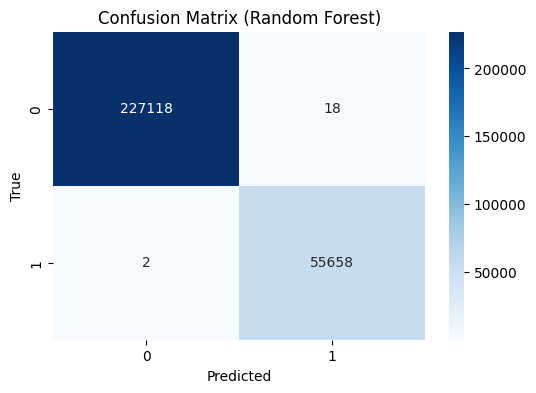

Outlier Percentage: {' Destination Port': 22.16827677902092, ' Flow Duration': 18.93502736955261, ' Total Fwd Packets': 11.777217499540305, ' Total Backward Packets': 10.913697506329651, 'Total Length of Fwd Packets': 15.489257273794538, ' Total Length of Bwd Packets': 21.835528083848427, ' Fwd Packet Length Max': 22.26711127455834, ' Fwd Packet Length Min': 0.5373131161685456, ' Fwd Packet Length Mean': 6.666819898442694, ' Fwd Packet Length Std': 23.480176523005984, 'Bwd Packet Length Max': 22.483698496442667, ' Bwd Packet Length Min': 3.0391165363017865, ' Bwd Packet Length Mean': 16.542666798681736, ' Bwd Packet Length Std': 22.777549894623686, 'Flow Bytes/s': 18.736297543105277, ' Flow Packets/s': 10.723631168757692, ' Flow IAT Mean': 20.588516103480956, ' Flow IAT Std': 21.480678651748963, ' Flow IAT Max': 20.945840818116242, ' Flow IAT Min': 18.12366511548961, 'Fwd IAT Total': 23.712322663686898, ' Fwd IAT Mean': 24.02084895118743, ' Fwd IAT Std': 23.45807578607901, ' Fwd IAT Ma

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

ValueError: could not convert string to float: ' Bwd Packet Length Std:0.0  Bwd Packet Length Mean:132.0  Destination Port:53.0  Average Packet Size:112.0  Packet Length Variance:2465.333333  Avg Bwd Segment Size:132.0  Max Packet Length:132.0  Packet Length Mean:74.66666667'

In [17]:
# Step 1: Set Up the Environment
!pip install transformers torch pandas numpy scikit-learn imbalanced-learn scipy matplotlib seaborn
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats import pearsonr, levene, kruskal
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from google.colab import drive
import gc

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 2: Load and Clean the CICIDS2017 Dataset
# zip_path = '/content/drive/MyDrive/CICIDS2017/network-intrusion-dataset.zip'
# extract_dir = '/content/cicids2017/'
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

csv_files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv'
]

dfs = []
for file in csv_files:
    file_path = os.path.join(extract_dir, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
print("Initial Dataset Shape:", df.shape)
print("Initial Label Distribution:\n", df[' Label'].value_counts())
min_samples = 20
label_counts = df[' Label'].value_counts()
valid_labels = label_counts[label_counts >= min_samples].index
df = df[df[' Label'].isin(valid_labels)]
print("After Filtering Rare Labels Shape:", df.shape)
print("Filtered Label Distribution:\n", df[' Label'].value_counts())
df[' Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
print("After Binary Conversion Shape:", df.shape)
print("Binary Label Distribution:\n", df[' Label'].value_counts())
_, df = train_test_split(df, test_size=0.2, stratify=df[' Label'], random_state=42)
print("After Subsampling Shape:", df.shape)
print("Subsampled Binary Label Distribution:\n", df[' Label'].value_counts())
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print("After Dropping NaN Shape:", df.shape)
print("Post-Cleaning Binary Label Distribution:\n", df[' Label'].value_counts())
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col != ' Label']
constant_features = [col for col in numerical_features if df[col].nunique() <= 1]
df = df.drop(columns=constant_features)
numerical_features = [col for col in numerical_features if col not in constant_features]
print("Removed Constant Features:", constant_features)
print("Final Dataset Shape:", df.shape)
print("Final Binary Label Distribution:\n", df[' Label'].value_counts())
if any(df[' Label'].value_counts() < 20):
    raise ValueError("One class has fewer than 20 samples after cleaning. Increase test_size or adjust min_samples.")
del dfs
gc.collect()

# Step 3: Preprocessing Pipeline
def get_numerical_categorical_features(df, target_col=' Label'):
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features = [col for col in numerical_features if col != target_col]
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_features = [col for col in categorical_features if col != target_col]
    return numerical_features, categorical_features

def correlation_analysis(df, numeric_features, threshold=0.8):
    corr_matrix = df[numeric_features].corr(method='pearson')
    high_corr = []
    for i in range(len(numeric_features)):
        for j in range(i + 1, len(numeric_features)):
            corr, _ = pearsonr(df[numeric_features[i]], df[numeric_features[j]])
            if abs(corr) > threshold:
                high_corr.append((numeric_features[i], numeric_features[j], corr))
    return high_corr, corr_matrix

def variance_analysis(df, numeric_features, target_col=' Label'):
    levene_results = {}
    for feature in numeric_features:
        groups = [df[df[target_col] == label][feature].dropna() for label in df[target_col].unique()]
        if all(len(group) >= 2 for group in groups) and all(group.var() > 0 for group in groups):
            try:
                stat, p = levene(*groups, center='median')
                levene_results[feature] = {'statistic': stat, 'p_value': p}
            except ValueError:
                levene_results[feature] = {'statistic': np.nan, 'p_value': np.nan}
        else:
            levene_results[feature] = {'statistic': np.nan, 'p_value': np.nan}
            print(f"Skipping Levene's Test for '{feature}' due to insufficient data or zero variance.")
    return levene_results

def feature_importance_kruskal(df, numeric_features, target_col=' Label'):
    kruskal_results = []
    for feature in numeric_features:
        groups = [df[df[target_col] == label][feature].dropna() for label in df[target_col].unique()]
        if all(len(group) >= 2 for group in groups) and all(group.nunique() > 1 for group in groups):
            try:
                stat, p = kruskal(*groups)
                kruskal_results.append({'Feature': feature, 'H_statistic': stat, 'p_value': p})
            except ValueError:
                kruskal_results.append({'Feature': feature, 'H_statistic': np.nan, 'p_value': np.nan})
        else:
            print(f"Skipping Kruskal-Wallis for '{feature}' due to insufficient data or identical values.")
            kruskal_results.append({'Feature': feature, 'H_statistic': np.nan, 'p_value': np.nan})
    return pd.DataFrame(kruskal_results)

def feature_importance_tree(df, numeric_features, target_col=' Label'):
    label_counts = df[target_col].value_counts()
    if any(label_counts < 2):
        print("Warning: Some classes have fewer than 2 samples. Falling back to previous feature list.")
        return pd.DataFrame({
            'Feature': [
                ' Max Packet Length', ' Packet Length Variance', ' Destination Port',
                ' Avg Bwd Segment Size', ' Packet Length Std', ' Average Packet Size',
                'Bwd Packet Length Max', ' Total Length of Bwd Packets'
            ],
            'Importance': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
        }), None, [0, 1], []
    try:
        df_sample, _ = train_test_split(df, test_size=0.5, stratify=df[target_col], random_state=42)
    except ValueError as e:
        print(f"Stratified sampling failed: {e}. Using non-stratified sampling.")
        df_sample, _ = train_test_split(df, test_size=0.5, random_state=42)
    X = df_sample[numeric_features]
    y = df_sample[target_col]
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf.fit(X, y)
    feature_importance = pd.DataFrame({
        'Feature': numeric_features,
        'Importance': clf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    cv_scores = []
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    labels = sorted(df[target_col].unique())
    del df_sample, X, y, clf
    gc.collect()
    return feature_importance, cm, labels, cv_scores

def outlier_percentage(df, numeric_features):
    outlier_results = {}
    for feature in numeric_features:
        sample = df[feature].sample(frac=0.1, random_state=42)
        Q1 = sample.quantile(0.25)
        Q3 = sample.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        outlier_results[feature] = (len(outliers) / len(df)) * 100
    return outlier_results

numerical_features, categorical_features = get_numerical_categorical_features(df)
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)
high_corr, corr_matrix = correlation_analysis(df, numerical_features)
print("Highly Correlated Features:", high_corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
levene_results = variance_analysis(df, numerical_features)
print("Levene's Test Results:", levene_results)
kruskal_df = feature_importance_kruskal(df, numerical_features)
print("Kruskal-Wallis Results:\n", kruskal_df)
feature_importance, cm, labels, cv_scores = feature_importance_tree(df, numerical_features)
print("Feature Importance (Tree Model):\n", feature_importance)
print("Cross-Validation F1 Scores:", cv_scores)
if cm is not None:
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Random Forest)')
    plt.show()
outlier_results = outlier_percentage(df, numerical_features)
print("Outlier Percentage:", outlier_results)
del corr_matrix
gc.collect()

# Step 4: Select Features and Convert to Text
if len(feature_importance) > 0:
    top_features = feature_importance['Feature'].head(8).tolist()
else:
    top_features = [
        ' Max Packet Length', ' Packet Length Variance', ' Destination Port',
        ' Avg Bwd Segment Size', ' Packet Length Std', ' Average Packet Size',
        'Bwd Packet Length Max', ' Total Length of Bwd Packets'
    ]
print("Selected Features:", top_features)
df_subset = df[top_features + [' Label']].copy()
def features_to_text(row):
    text = " ".join([f"{col}:{row[col]}" for col in top_features])
    return text
df_subset['text'] = df_subset.apply(features_to_text, axis=1)
X = df_subset['text']
y = df_subset[' Label']
print("Label Distribution Before Split:\n", y.value_counts())
try:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
except ValueError as e:
    print(f"Stratified split failed: {e}. Using non-stratified split.")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
try:
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
except ValueError as e:
    print(f"Stratified split failed: {e}. Using non-stratified split.")
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Train Size:", len(X_train))
print("Validation Size:", len(X_val))
print("Test Size:", len(X_test))
print("Train Label Distribution:\n", y_train.value_counts())
print("Validation Label Distribution:\n", y_val.value_counts())
print("Test Label Distribution:\n", y_test.value_counts())
del df, df_subset
gc.collect()

# Step 5: Tokenize and Create Datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Swap with 'secbert-model-name'
class CICIDSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
train_dataset = CICIDSDataset(X_train, y_train, tokenizer)
val_dataset = CICIDSDataset(X_val, y_val, tokenizer)
test_dataset = CICIDSDataset(X_test, y_test, tokenizer)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Step 6: Handle Imbalanced Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.values.reshape(-1, 1), y_train)
X_train_resampled = pd.Series(X_train_resampled.flatten())
y_train_resampled = pd.Series(y_train_resampled)
train_dataset = CICIDSDataset(X_train_resampled, y_train_resampled, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("Resampled Train Label Distribution:\n", y_train_resampled.value_counts())

# Step 7: Set Up and Train the SecBERT Model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',  # Swap with 'secbert-model-name'
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc, val_precision, val_recall, val_f1, _, _ = eval_model(model, val_loader, device)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# Step 8: Evaluate and Save the Model
test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = eval_model(model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
output_dir = '/content/drive/MyDrive/CICIDS2017/secbert_model/'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")